# Распознавание эмоций

Задача проекта - улучшить опыт от посещения музеев, городов или новых мест с помощью информационных технологий.
Цель - сделать посещение людьми музеев, городов или новых мест интересным, информативным и комфортным.

## Предлагаемое решение

[Ссылка на репозиторий с подробным описанием](https://github.com/aniyur/skillfactory-ds-hackaton-23)

Реализуем систему распознавания эмоций, которую можно будет использовать для автоматического определения
получаемых людьми эмоций от просмотра, например, музейных экспонатов и т. п. Затем можно будет предлагать
людям для посещения на выбор места, вызывающие интересующие их эмоции. Либо подбирать наиболее
интересующие людей экспонаты и т. п.

[Ссылка на Kaggle](https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data)

### Настройки модели и обучения

In [1]:
# 1 - small, 2 - medium, 3 - large
model_version = 2
clip = 1e-5
dropout = 0.98
weight_decay = 0
lr = 0.0001
num_frozen_epochs = 10
num_epochs = 1000
batch_size = 32 if model_version == 3 else 64
IMAGE_SIZE = (224, 224)
normalize = True

### Импортируем необходимые нам библиотеки

In [2]:
import os
import pandas as pd
import torch
import collections
from torch import nn
from torchvision.transforms import v2 as v2_transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet
import torchvision.models as tv_models
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import seaborn as sns
import random
import numpy as np

### Закрепим состояние PRNG для воспроизводимости

In [3]:

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

### Определим доступное вычислительное устройство

In [4]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Device: {device}')

Device: cuda


### Посмотрим метаданные

In [5]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


## Посмотрим количество примеров по классам

<Axes: xlabel='label', ylabel='count'>

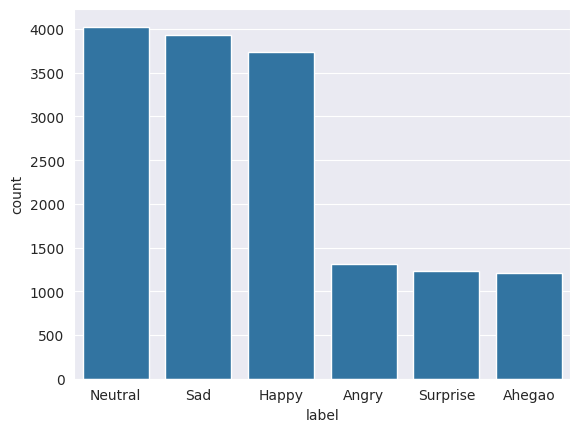

In [6]:
sns.countplot(x=df['label'], order=df.groupby('label')['label'].count().sort_values(ascending=False).index)

### Создадим загрузчик картинок нашего датасета

In [7]:
dataset = ImageFolder('dataset')

### Посмотрим некоторые картинки, входящие в датасет

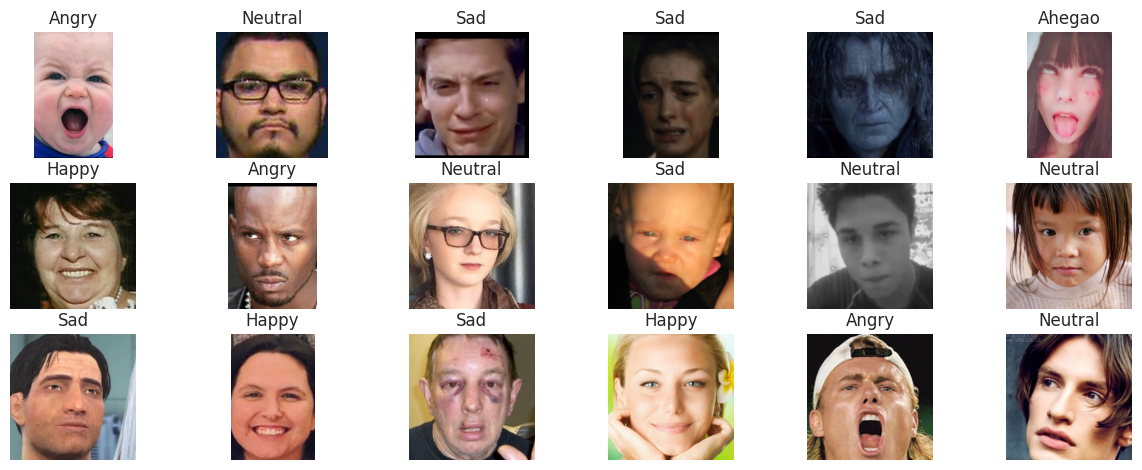

In [8]:
indexes = random.sample(range(0, len(dataset)), 18)
plt.figure(figsize=(15, 35))
for n, i in enumerate(indexes):
    img, label = dataset[i]
    ax = plt.subplot(18, 6, n + 1)
    plt.imshow(img)
    plt.title(dataset.classes[label])
    plt.axis("off")

### Разобьём на тренировочный и валидационный сабсет

In [9]:
val_size = len(dataset) // 5
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12363
Length of Validation Data : 3090


### Подсчитаем гиперпараметры нормализации (среднее и стд)

In [10]:
class MapDataset(torch.utils.data.Dataset):
    """
    see https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
    
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn=None):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index]) if self.map else self.dataset[index]

    def __len__(self):
        return len(self.dataset)


basic_transforms = [
    v2_transforms.ToImage(),
    v2_transforms.ToDtype(torch.float32, scale=True),
    v2_transforms.Resize(IMAGE_SIZE, antialias=True),
]

basic_transformer = v2_transforms.Compose(basic_transforms)
train_norm_dl = DataLoader(MapDataset(train_data, basic_transformer), batch_size, num_workers=4, pin_memory=True, shuffle=False)

def batch_mean_and_sd(loader):
    """see https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html"""

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return mean, std

mean, std = batch_mean_and_sd(train_norm_dl)
# mean = [0.5432, 0.4287, 0.3821]
# std = [0.2862, 0.2541, 0.2465]

del train_norm_dl
print(f'Mean: {mean}, std: {std}')

Mean: tensor([0.5432, 0.4287, 0.3821]), std: tensor([0.2862, 0.2541, 0.2465])


### Нормализация и аугментация

In [11]:
norm_transform = v2_transforms.Normalize(mean=mean, std=std)
normalizations = [norm_transform] if normalize else []

val_transforms = v2_transforms.Compose(basic_transforms + normalizations)

train_transforms = v2_transforms.Compose([
    v2_transforms.ToImage(),
    v2_transforms.ToDtype(torch.float32, scale=True),
    v2_transforms.RandomAffine(
        degrees=(-5, 5),
        scale=(0.75, 1.25),
        translate=(0.2, 0.2),
        shear=(-5, 5, -5, 5),
    ),
    v2_transforms.ColorJitter(
        brightness=(0.8, 1.2),
        contrast=(0.8, 1.2),
        saturation=(0.7, 1.3),
        hue=(-0.1, 0.1),
    ),
    v2_transforms.RandomHorizontalFlip(),
    v2_transforms.Resize(IMAGE_SIZE, antialias=True),
    *normalizations,
])

val_data = MapDataset(val_data, val_transforms)
train_data = MapDataset(train_data, train_transforms)

val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True, shuffle=False)
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)

### Посмотрим несколько нормализованных и аугментированных картинок

/tmp/ipykernel_16642/1364347893.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_t = torch.tensor(mean).detach().view(-1, 1, 1) if normalize else 0
/tmp/ipykernel_16642/1364347893.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_t = torch.tensor(std).detach().view(-1, 1, 1) if normalize else 1


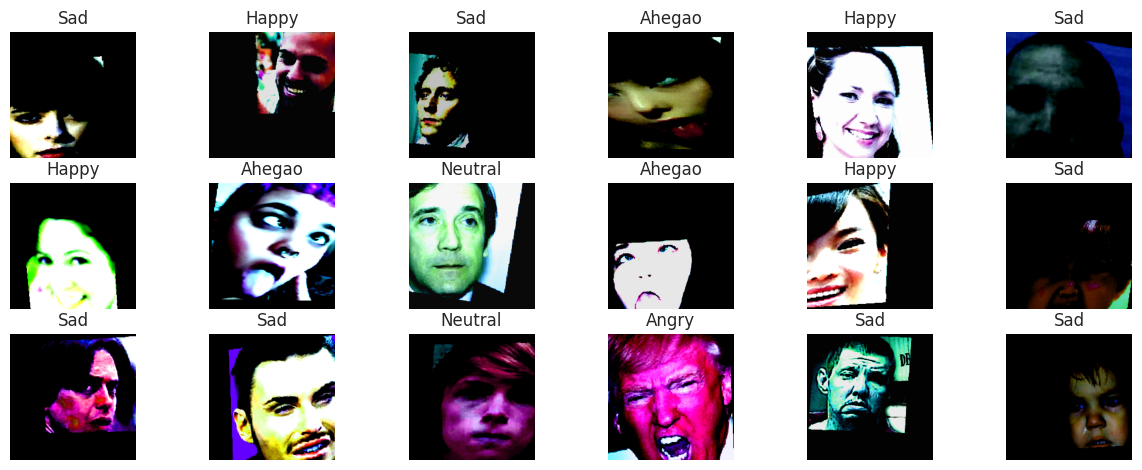

In [12]:
indexes = random.sample(range(0, len(train_data)), 18)
plt.figure(figsize=(15, 35))
mean_t = torch.tensor(mean).detach().view(-1, 1, 1) if normalize else 0
std_t = torch.tensor(std).detach().view(-1, 1, 1) if normalize else 1
for n, i in enumerate(indexes):
    img, label = train_data[i]
    ax = plt.subplot(18, 6, n + 1)
    img = train_transforms(img)
    img = img * std_t
    img = img + mean_t
    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[label])
    plt.axis("off")

### Архитектура модели

Вдохновение [отсюда](https://www.kaggle.com/code/guanlintao/efficientnetv2-emotion-recognition)

In [13]:
class Model(nn.Module):
    def __init__(self, model_version: int = 1, dropout: float = 0.975):
        super().__init__()
        num_classes = 6
        self.model_version = model_version
        model_factories = [tv_models.efficientnet_v2_s, tv_models.efficientnet_v2_m, tv_models.efficientnet_v2_l]
        model_weights = [efficientnet.EfficientNet_V2_S_Weights.IMAGENET1K_V1,
                         efficientnet.EfficientNet_V2_M_Weights.IMAGENET1K_V1,
                         efficientnet.EfficientNet_V2_L_Weights.IMAGENET1K_V1]
        self.base = model_factories[model_version-1](weights=model_weights[model_version-1])
        self.freeze_params()
        self.base.classifier[0] = nn.Dropout(dropout, inplace=True)
        self.base.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
        self.base.classifier.add_module('2', nn.Softmax(dim=1))
        self.to(device)
        
    def freeze_params(self):
        for i in self.base.parameters():
            i.requires_grad = False

    def unfreeze_params(self):
        for i in self.base.parameters():
            i.requires_grad = True
        
    def forward(self, xb):
        return self.base(xb)

    def training_step(self, batch):
        images, labels = batch
        labels = labels.to(device)
        out = self(images.to(device))
        acc = accuracy(out, labels)
        loss = F.cross_entropy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        labels = labels.to(device)
        out = self(images.to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {} train loss: {:.4f}, val loss: {:.4f}, train acc: {:.4f}, val acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))
        if epoch % 5 == 0 and epoch > 10:
            path = os.path.expanduser(f'~/data/torch/model_{self.model_version}_{epoch}.th')
            torch.save(self.state_dict(), path)
            # print(f"written '{path}'")

### Подсчёт точности

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Валидация

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

### Тренировка

In [16]:
def fit(epochs, lr, model, train_loader, val_loader, optimizer_class, weight_decay=None):
    history = collections.defaultdict(list)
    optimizer = optimizer_class(filter(lambda p: p.requires_grad, model.parameters()), lr, weight_decay=weight_decay)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        
        if epoch + 1 == num_frozen_epochs:
            print('...unfreezing pretrained parameters...')
            model.unfreeze_params()
            del optimizer
            torch.cuda.empty_cache()
            optimizer = optimizer_class(filter(lambda p: p.requires_grad, model.parameters()), lr, weight_decay=weight_decay)
        
        for k, v in result.items():
            history[k].append(v)

    return history, optimizer

optimizer = torch.optim.Adam

### Посмотрим, сколько параметров в нашей модели

In [17]:
model = Model(model_version, dropout=dropout)
print(f'Model version: {model_version}')
num_parameters = 0
for p in model.parameters():
    c = 1
    for size in p.size():
        c *= size
    num_parameters += c
print(f'Parameters count: {num_parameters}')
model

Model version: 2
Parameters count: 52866042


Model(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0

### Непосредственно обучение

In [ ]:
history, opt = fit(num_epochs, lr, model, train_dl, val_dl, optimizer, weight_decay=weight_decay)

Epoch 1 train loss: 1.7973, val loss: 1.7759, train acc: 0.1822, val acc: 0.2361
Epoch 2 train loss: 1.7806, val loss: 1.7599, train acc: 0.2123, val acc: 0.2968
Epoch 3 train loss: 1.7684, val loss: 1.7514, train acc: 0.2317, val acc: 0.3234
Epoch 4 train loss: 1.7616, val loss: 1.7423, train acc: 0.2399, val acc: 0.3510
Epoch 5 train loss: 1.7610, val loss: 1.7403, train acc: 0.2392, val acc: 0.3591
Epoch 6 train loss: 1.7530, val loss: 1.7284, train acc: 0.2515, val acc: 0.3722
Epoch 7 train loss: 1.7473, val loss: 1.7185, train acc: 0.2623, val acc: 0.3772
Epoch 8 train loss: 1.7447, val loss: 1.7191, train acc: 0.2646, val acc: 0.3969
Epoch 9 train loss: 1.7434, val loss: 1.7128, train acc: 0.2648, val acc: 0.3982
Epoch 10 train loss: 1.7300, val loss: 1.7068, train acc: 0.2859, val acc: 0.4047
>>> unfreezing pretrained parameters <<<
Epoch 11 train loss: 1.7210, val loss: 1.6270, train acc: 0.2943, val acc: 0.4808
Epoch 12 train loss: 1.6642, val loss: 1.5153, train acc: 0.3626, 